In [52]:
import torch
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.utils import make_grid
from image_model import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from metrics import *

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [53]:
# path to the images
local_path = r'E:\课件\2024fall\ENEL 645\Assignment 2\ENEL645_Assignment1_ChunshengXiao'

In [67]:
# Transforms 
torchvision_transform = transforms.Compose([
  transforms.Resize(270),                                 # change input size
  transforms.CenterCrop(224),                             # change input size
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [68]:
# Load datasets
test_dataset = ImageFolder(root=local_path, transform=torchvision_transform)

In [69]:
# Define batch size and number of workers (adjust as needed)
batch_size = 32
num_workers = 4

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [70]:
for (i, data) in enumerate(test_loader, 0):
  print(data[0].shape)

torch.Size([32, 3, 224, 224])


In [71]:
class_names = test_dataset.classes
print(class_names)
print("Train set:", len(test_loader)*batch_size)

['Black', 'Blue', 'Green', 'TTR']
Train set: 32


In [72]:
test_iterator = iter(test_loader)
test_batch = next(test_iterator)        # test_batch: [tensor(images), tensor(labels)]

In [73]:
print(test_batch[1].shape)

torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


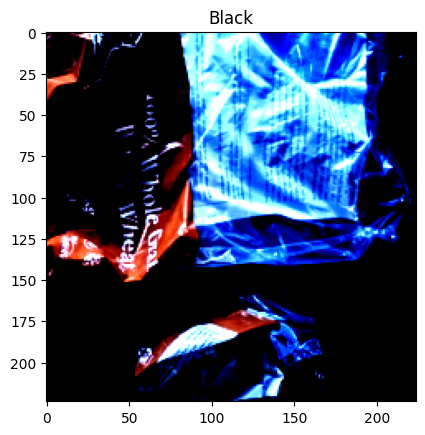

In [85]:
rand_int = np.random.randint(0, 32)
plt.figure()
plt.imshow(test_batch[0].numpy()[rand_int].transpose(1,2,0))
plt.title(class_names[test_batch[1][rand_int]])
plt.show()

In [ ]:
# Evaluation on loss and accuracy from image model
# All results come from the output of text model in slurm-27981.out


In [75]:
# display result on images
# get the model
img_model_path = 'garbage_net.pth'
image_model_test = GarbageModel(num_classes=4, transfer=False)
image_model_test.load_state_dict(torch.load(img_model_path, map_location=torch.device('cpu')))

C:\Users\gz_xh\AppData\Local\Temp\ipykernel_21600\3456387442.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_model_test.load_state_dict(torch.load(img_model_path, 

<All keys matched successfully>

In [77]:
"""
This function visualizes the model's results
"""
def visualize_model(model, data_loader, class_name, num_img=8):
  model.eval()                # set the mode to evaluate to freeze the weight

  fig = plt.figure()          # figure handle to visualize the result

  # freeze all the weights since we are showing the results
  with torch.no_grad():
    for (i, data) in enumerate(data_loader, 0):

      inputs = data[0]
      labels = data[1]

      outputs = model(inputs)           # get the prediction
      _,pred = torch.max(outputs, 1)   # the largest probability is the prediction

      for j in range(1, len(inputs)):

        ax = plt.subplot(num_img//2, 2, j)
        ax.axis('off')
        ax.set_title(f'predicted: {class_name[pred[j]]}')
        ax.imshow(inputs[j].numpy().transpose(1,2,0))

        # skip the visualization if we get enough images
        if j == num_img:
          break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6680672..2.060536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.5702832].
Exception ignored in: <function _ConnectionBase.__del__ at 0x000001A42C3E69D0>
Traceback (most recent call last):
  File "C:\Users\gz_xh\AppData\Loc

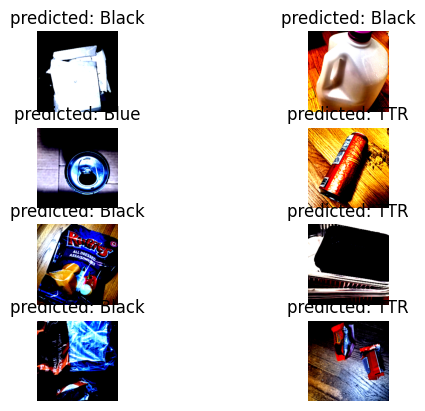

In [78]:
visualize_model(image_model_test, test_loader, class_names)